In [1]:
import numba
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit
import scipy
from scipy.spatial.transform import Rotation as Rot
import Swimmer
plt.rc('text', usetex=True)
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [2]:
T=1
R=1
a = 10*R
epsilons = np.linspace(0.1,5,50)*R

steps = 1000
nsteps = 1000
dt = T/steps
#initial positions 
r0 = np.array([[0, 0, 0],
[0, 0, a],
[a*np.sqrt(8)/3, 0 , -a/3],
[-a*np.sqrt(8)/6, a*np.sqrt(24)/6 , -a/3],
[-a*np.sqrt(8)/6, -a*np.sqrt(24)/6, -a/3]])

In [4]:
def getR0(ls):
    a1,a2,a3,a4 = ls
    
    R0 = [[0, 0, 0],
    [0, 0, a1],
    [a2*np.sqrt(8)/3, 0 , -a2/3],
    [-a3*np.sqrt(8)/6, a3*np.sqrt(24)/6 , -a3/3],
    [-a4*np.sqrt(8)/6, -a4*np.sqrt(24)/6, -a4/3]]
    
    return np.array(R0)

In [5]:
@njit
def getDistanceMatrix(A):   # dij = rj - ri
    tiledPoses = tile(A)
    distances = tiledPoses - tiledPoses.transpose((1,0,2))
    return distances

In [6]:
@njit
def tile(x):
    tiled = np.zeros((5,5,3))
    for i in range(5):
        tiled[i,:,:] = x
        
    return tiled


In [7]:
@njit
def tile2(x):
    tiled = np.zeros((5,5,3,3))
    for i in range(3):
        for j in range(3):
            tiled[:,:,i,j] = x
        
    return tiled

In [8]:
@njit
def getO(d):
    d2 = d**2    
    drNorm = np.sum(d2,axis=2)**0.5
            
    
    I5_5_3_3 = np.zeros((5,5,3,3))

    for i in range(5):
        for j in range(5):
            I5_5_3_3[i,j,:,:] = np.eye(3)

    c1 = d.reshape(5,5,3,1)
    c2 = c1.transpose(0,1,3,2)    
    B = np.multiply(c1,c2)    
    c3 = tile2(drNorm)


    O = R*(I5_5_3_3 + B/(c3**2))*0.75/c3 #*R/norm(l)
    
    for i in range(5):  #for i=j
        O[i,i,:,:] = np.eye(3)

    return O

In [9]:
@njit
def getRR(r):
    rr0 = np.array([
    
    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]])
    
    
    rr1 = np.array([[0, -r[0,2] , r[0,1],  0, -r[1,2] , r[1,1],    0, -r[2,2] , r[2,1], 0, -r[3,2] , r[3,1]   ,0, -r[4,2] , r[4,1]],
    [r[0,2], 0 , -r[0,0],   r[1,2], 0 , -r[1,0],  r[2,2], 0 , -r[2,0],  r[3,2], 0 , -r[3,0],  r[4,2], 0 , -r[4,0]],
    [-r[0,1], r[0,0], 0 , -r[1,1], r[1,0], 0 , -r[2,1], r[2,0], 0 ,   -r[3,1], r[3,0], 0 ,  -r[4,1], r[4,0], 0 ]])
    
    


    
    return np.concatenate((rr0,rr1),axis=0)

In [10]:
@njit
def getOO(d):
    ##Check
    k2_3 = np.dot(d[1,0],d[1,0])*np.dot(d[2,0],d[2,0])/np.dot(d[1,0],d[2,0])
    k2_4 = np.dot(d[1,0],d[1,0])*np.dot(d[3,0],d[3,0])/np.dot(d[1,0],d[3,0])
    k2_5 = np.dot(d[1,0],d[1,0])*np.dot(d[4,0],d[4,0])/np.dot(d[1,0],d[4,0])
    k3_4 = np.dot(d[2,0],d[2,0])*np.dot(d[3,0],d[3,0])/np.dot(d[2,0],d[3,0])
    k3_5 = np.dot(d[2,0],d[2,0])*np.dot(d[4,0],d[4,0])/np.dot(d[2,0],d[4,0])

    p2_3 = np.dot(d[2,0],d[2,0])*d[0,1] - k2_3*d[0,2] 
    p2_4 = np.dot(d[3,0],d[3,0])*d[0,1] - k2_4*d[0,3] 
    p2_5 = np.dot(d[4,0],d[4,0])*d[0,1] - k2_5*d[0,4] 
    p3_4 = np.dot(d[3,0],d[3,0])*d[0,2] - k3_4*d[0,3] 
    p3_5 = np.dot(d[4,0],d[4,0])*d[0,2] - k3_5*d[0,4] 


    q2_3 = np.dot(d[1,0],d[1,0])*d[0,2] - k2_3*d[0,1] 
    q2_4 = np.dot(d[1,0],d[1,0])*d[0,3] - k2_4*d[0,1] 
    q2_5 = np.dot(d[1,0],d[1,0])*d[0,4] - k2_5*d[0,1] 
    q3_4 = np.dot(d[2,0],d[2,0])*d[0,3] - k3_4*d[0,2] 
    q3_5 = np.dot(d[2,0],d[2,0])*d[0,4] - k3_5*d[0,2] 
    
    
    OO = np.array([
        [d[1,0,0], d[1,0,1], d[1,0,2], -d[1,0,0], -d[1,0,1], -d[1,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [d[2,0,0], d[2,0,1], d[2,0,2], 0, 0, 0, -d[2,0,0], -d[2,0,1], -d[2,0,2], 0, 0, 0, 0, 0, 0,   ],   
    [d[3,0,0], d[3,0,1], d[3,0,2], 0, 0, 0, 0, 0, 0, -d[3,0,0], -d[3,0,1], -d[3,0,2], 0, 0, 0],
    [d[4,0,0], d[4,0,1], d[4,0,2], 0, 0, 0, 0, 0, 0, 0, 0, 0, -d[4,0,0], -d[4,0,1], -d[4,0,2]],
    
    [-p2_3[0] -q2_3[0], -p2_3[1] -q2_3[1], -p2_3[2] -q2_3[2],                p2_3[0], p2_3[1], p2_3[2], q2_3[0], q2_3[1], q2_3[2], 0, 0, 0, 0, 0, 0], #2_3,
    [-p2_4[0] -q2_4[0], -p2_4[1] -q2_4[1], -p2_4[2] -q2_4[2],                p2_4[0], p2_4[1], p2_4[2], 0, 0, 0, q2_4[0], q2_4[1], q2_4[2], 0, 0, 0],  #2_4,
    [-p2_5[0] -q2_5[0], -p2_5[1] -q2_5[1], -p2_5[2] -q2_5[2],                p2_5[0], p2_5[1], p2_5[2], 0, 0, 0, 0, 0, 0, q2_5[0], q2_5[1], q2_5[2]], #2_5
    [-p3_4[0] -q3_4[0], -p3_4[1] -q3_4[1], -p3_4[2] -q3_4[2],                0, 0, 0, p3_4[0], p3_4[1], p3_4[2], q3_4[0], q3_4[1], q3_4[2], 0, 0, 0],  #3_4
    [-p3_5[0] -q3_5[0], -p3_5[1] -q3_5[1], -p3_5[2] -q3_5[2],                0, 0, 0, p3_5[0], p3_5[1], p3_5[2], 0, 0, 0, q3_5[0], q3_5[1], q3_5[2]] #3_5
    
    ])
    
    return OO


In [11]:
@njit
def getC(l,u):
    lu = np.zeros(4)
    for i in range(4):
        lu[i]= (l[i]*u[i])
        
    
    return np.array([*list(lu), 0,0,0,0,0,0,0,0, 0,0,0])  

#  u -> u/steps maybe

In [12]:
def getV(r,l,u):
    d = getDistanceMatrix(r)

    O = getO(d)
    newO = np.zeros((15,15))
    for i in range(5):
        for j in range(5):
            newO[3*i:3*i+3,3*j:3*j+3] = O[i,j]
        
    rr= getRR(r)
    mm = np.linalg.inv(newO)


    NN = np.matmul(rr,mm)
    OO = getOO(d)
    AA = np.concatenate((OO,NN),axis=0)
    
    
    

    BB = getC(l,u)
    
    return np.linalg.solve(AA,BB)
        
        
        

In [13]:
def step(r,L):
    for t in range(nsteps):
        try:
            U = L[:,t+1]-L[:,t]
        except IndexError:
            U = L[:,t]-L[:,t-1]
            
        v = getV(r,L[:,t],U).reshape((5,3))
        
        r += v  ##########
        
        
    return r    

In [14]:
def act(L):
    r = getR0(L[:,0])
    r_final = step(r.copy(),L)
    delta = list(r_final - r)[0]

    # dTheta = getTheta(r_final) - getTheta(r)
    # dPhi = getPhi(r_final) - getPhi(r)
    
    # np.matmul(getE(rf6), np.linalg.inv(getE(r0)))
    
    return r_final,delta,np.matmul(getE(r_final), np.linalg.inv(getE(r)))

In [15]:
def getE(r):
    e1 = ((r[1]-r[0])/np.linalg.norm((r[1]-r[0]))).reshape((3,1))
    e2 = ((r[2]-r[0])/np.linalg.norm((r[2]-r[0]))).reshape((3,1))
    e3 = ((r[3]-r[0])/np.linalg.norm((r[3]-r[0]))).reshape((3,1))
    
    return np.concatenate((e1,e2,e3),axis=1)
    

### Saving Data for epsilon = 3 

In [16]:
@njit
def getAction(state,ratio):
    #t=1 if state=0 and t = ratio if state = 1   ???
    t1,t2,t3,t4 = np.where(state==0,1,ratio)
    sum = t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4
    #probs = np.array([t2*t3*t4/sum,t1*t3*t4/sum,t1*t2*t4/sum,t2*t3*t1/sum])
    randomNumber = np.random.uniform(0,1,1)
    if randomNumber <= t4*t2*t3/sum:
        changingJoint = 0
    elif(randomNumber <= (t4*t3*t1+t4*t2*t3)/sum):  
        changingJoint = 1
    elif randomNumber <= (t4*t2*t1+t4*t2*t3+t4*t3*t1)/sum:
        changingJoint = 2
    else:
        changingJoint = 3


    # if state[changingJoint] == 0:
    #     deltat = ratio
    # else:
    #     deltat = 1


    # return changingJoint, 1 / deltat    
    return changingJoint,getDeltat2(t1,t2,t3,t4)


@njit
def doStep(Data,state,ratio):
    action,deltat = getAction(state,ratio)
    new_state = state.copy()
    new_state[action] = 1 - new_state[action]
    delta = Data[fromBinary(state)*4 + action][0,:]  #???
    rotation = Data[fromBinary(state)*4 + action][1:,:]
    return new_state,delta,rotation,deltat


In [17]:
states = np.zeros((10,4),dtype=np.int64)


In [18]:
@njit
def getDeltat(t1,t2,t3,t4,tc):
    tav = 18.844
    return ((1-1/(tav*t1))*(1-1/(tav*t2))*(1-1/(tav*t3))*(1-1/(tav*t4))*tav/tc)/(((1/t1 + 1/t2 + 1/t3 + 1/t4)**2)*(1-1/(tav*tc)))

In [19]:
@njit
def getDeltat2(t1,t2,t3,t4):
    return 1/(1/t1 + 1/t2 + 1/t3 + 1/t4)

## P(t1,t2,t3,t4) = t2*t3*t4/(t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4)

In [20]:
@njit
def getBinary(int: a):
    return np.array([int//8,(int%8)//4,(int%4)//2,int%2])
@njit 
def fromBinary(binary):
    x = 0
    for i in range(len(binary)):
        x += binary[::-1][i]*(2**i)
    return x

@njit 
def fromBinary2d(binaries):
    x = np.zeros(binaries.shape[0],dtype=np.int64)
    for i in range(binaries.shape[0]):
        x[i] = fromBinary(binaries[i])
    return x

In [21]:
def getAllPossibleActions(a,epsilon,steps):
    
    closing = a - np.arange(steps+1)*epsilon/steps
    closed = (a-epsilon)*np.ones(steps+1)
    opening = a - epsilon + np.arange(steps+1)*epsilon/steps
    opened  = a *np.ones(steps+1)
    
    possibleActions = np.zeros((64,4,steps+1))
    
    
    
    for i in range(16):
        for j in range(4):
            actionBinaryState = getBinary(i)
            # closed for 0 and opened for 1 
            ca = np.array([closed,closed,closed,closed])*actionBinaryState.reshape(4,1) + np.array([opened,opened,opened,opened])*(1-actionBinaryState).reshape(4,1)
            if actionBinaryState[j] == 0:
                ca[j,:] = opening
            else:
                ca[j,:] = closing
                
            possibleActions[4*i+j] = ca 
        
    return possibleActions

In [22]:
epsilon = 3
allPossbileActions = getAllPossibleActions(a,epsilon, steps)
np.save("allPossbileActions",allPossbileActions)

In [23]:
allPossbileActions = np.load("allPossbileActions.npy")

## Data Collection for epsilon = 3

In [25]:
actionsData = np.zeros((64,4,3))

for i in range(64):
    print(i)
    _,delta,Rotation = act(allPossbileActions[i])
    actionsData[i,0,:] = delta
    actionsData[i,1:4,:] = Rotation
    
np.save("actionDatasForE=3",actionsData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [24]:
actionsData = np.load("actionDatasForE=3.npy")

In [25]:
@njit
def perturbe(Data,perturbingSteps,ratio):
    time = 0
    pertrubingPose = np.array([0.,0.,0.])
    perturbingRotation = np.eye(3)
    state = np.ones(4,dtype=np.int64)
    pertrubingPoses = np.zeros((perturbingSteps,3))
    pertrubingTimes = np.zeros(perturbingSteps)
        
    for t in range(perturbingSteps):
        newState,delta,rotation,deltat = doStep(Data,state,ratio)
        state = newState
        pertrubingPose += perturbingRotation @ delta
        perturbingRotation = rotation @ perturbingRotation
        pertrubingPoses[t] = pertrubingPose
        time += deltat
        pertrubingTimes[t] = time
        
    return pertrubingPoses,pertrubingTimes

In [26]:
perturbe(actionsData,1000,1)

/tmp/ipykernel_64540/318006993.py:11: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  newState,delta,rotation,deltat = doStep(Data,state,ratio)
/tmp/ipykernel_64540/318006993.py:14: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  perturbingRotation = rotation @ perturbingRotation


(array([[ 9.23204540e-18, -5.41258007e-18,  5.57630488e-01],
        [ 5.26016967e-01, -6.62356634e-18,  3.74065100e-01],
        [ 3.00278883e-05, -7.12732367e-18,  5.57608442e-01],
        ...,
        [-5.33995873e-01,  4.02271739e-02, -4.77792767e-01],
        [-5.59511134e-01,  8.44266543e-02,  7.19483268e-02],
        [-4.27031493e-02,  1.12283654e-01, -8.77291289e-02]]),
 array([  0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,
          2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,
          4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,
          6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,
          8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,
         10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,
         12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,
         14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,
         16.25,  16.5 ,  16.75,  17.  ,  17

In [27]:
@njit
def getPerturbingDiffusionCoefForRatio(Data,ratio,iterations=1000,perturbingSteps=1000):
    # iterations = 10_00
    # perturbingSteps = 10_00
    meanFinalPoses = np.zeros((perturbingSteps))
    meanFinalTimes = np.zeros(perturbingSteps)
    for iteration in range(iterations):
        pertrubingPoses,pertrubingTimes = perturbe(Data,perturbingSteps,ratio)
        #print(np.sum(np.square(pertrubingPoses[:]),axis=1).shape,meanFinalPoses.shape)
        meanFinalPoses +=   np.sum(np.square(pertrubingPoses[:]),axis=1)
        meanFinalTimes += pertrubingTimes
        #print(iteration)
     
    return meanFinalTimes/iterations,meanFinalPoses/iterations

def getPerturbingDiffusionCoef(Data,ratios,iterations=1000,perturbingSteps=1000):
    diffs =np.zeros(ratios.shape)
    for i in range(ratios.shape[0]):
        print(i)
        meanFinalTimes,meanFinalPoses= getPerturbingDiffusionCoefForRatio(Data,ratios[i],iterations,perturbingSteps)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(meanFinalTimes,meanFinalPoses)
        diffs[i] =  slope 
    return diffs


In [29]:
getPerturbingDiffusionCoefForRatio(actionsData,1)

(array([  0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,
          2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,
          4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,
          6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,
          8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,
         10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,
         12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,
         14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,
         16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,  18.  ,
         18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,  20.  ,
         20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,  22.  ,
         22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,  24.  ,
         24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,  26.  ,
         26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75, 

In [3]:
ratios = np.exp(np.linspace(-5,5,50))

In [50]:
diffs = getPerturbingDiffusionCoef(actionsData,ratios,100,10000)

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [52]:
diffs2 = getPerturbingDiffusionCoef(actionsData,ratios,1000,10000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [1]:
np.save("diffs1",diffs2)
plt.plot(np.log(ratios),diffs2/6)  #### /6
#plt.savefig("plot33.png")

NameError: name 'np' is not defined

In [4]:
diffs2 = np.load("./diffs1.npy")

In [31]:
np.save("diffs1",diffs2)


In [165]:
np.arange(-35,36,3)/10 + np.log(ratios[18])

array([-4.82653061, -4.52653061, -4.22653061, -3.92653061, -3.62653061,
       -3.32653061, -3.02653061, -2.72653061, -2.42653061, -2.12653061,
       -1.82653061, -1.52653061, -1.22653061, -0.92653061, -0.62653061,
       -0.32653061, -0.02653061,  0.27346939,  0.57346939,  0.87346939,
        1.17346939,  1.47346939,  1.77346939,  2.07346939])

In [32]:
np.where(np.log(diffs2) == np.max(np.log(diffs2)))

(array([18]),)

In [33]:
thers = np.max(diffs2) - 2*np.var(diffs2)

In [34]:
np.where(diffs2 >= thers)

(array([18]),)

In [35]:
np.exp(np.arange(-5,6)/10 + np.log(ratios[18])) 

array([0.16097107, 0.17790055, 0.19661051, 0.21728822, 0.24014062,
       0.26539643, 0.29330842, 0.32415593, 0.35824771, 0.39592495,
       0.43756474])

In [36]:
np.log(ratios[18]),ratios[18]

(-1.3265306122448979, 0.26539642902432975)

In [37]:
np.max(diffs2 )

0.0003742127868186312

In [38]:
ratios[np.argmax(diffs2)]

0.26539642902432975

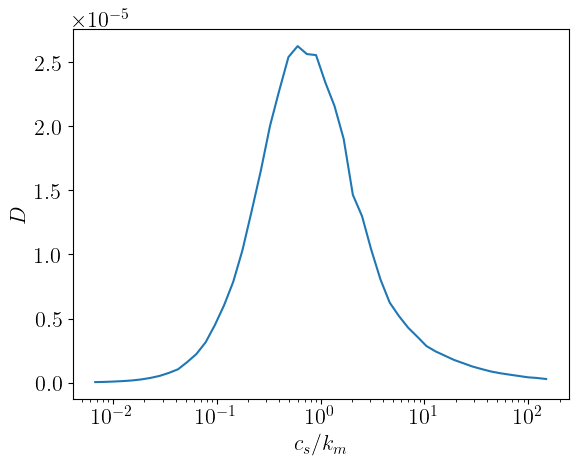

In [5]:
plt.semilogx(ratios,diffs2/6*ratios )
plt.xlabel("$c_s/k_m$")
plt.ylabel("$D$")
plt.savefig("5_1.png")

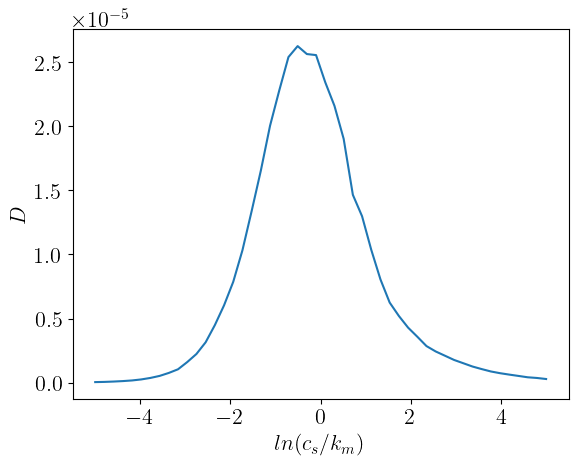

In [8]:
plt.plot(np.log(ratios),diffs2/6*ratios )
plt.xlabel("$ln(c_s/k_m)$")
plt.ylabel("$D$")
plt.savefig("5_1.png")

In [40]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [14]:
np.max(diffs2/6*ratios),ratios[np.argmax(diffs2/6*ratios)]

(2.6277362643109944e-05, 0.6003730411984047)

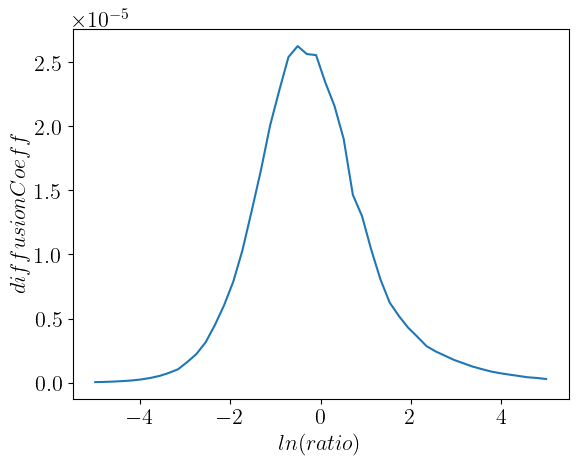

In [12]:
plt.plot(np.log(ratios),ratios*diffs2/6 )
plt.xlabel("$ln(ratio)$")
plt.ylabel("$diffusion Coeff$")
plt.savefig("5_1.png", bbox_inches="tight")


## Oriented randomwalk

In [72]:
@njit
def getOrientedAction(state,ratio,rotation,grad):
     #TODO *ratio
    #t=1 if state=0 and t = ratio if state = 1
    # print(np.dot(rotation,r0.T).T,cGrad)
    # print(np.dot(np.dot(rotation,r0.T).T,cGrad))

    grad = ratio*np.array([0., 0., grad])   #TODO
    #ratios = ratio + np.dot(np.dot(rotation,r0[1:].T).T,grad)
    ratios = ratio + np.dot((rotation @ (r0[1:].T)).T,grad)

    
    t1,t2,t3,t4 = np.where(state==0,np.ones(4),ratios)
    #print(t1,t2,t3,t4)
    
    sum = t1*t2*t3 + t1*t2*t4 + t1*t3*t4 + t2*t3*t4
    #probs = np.array([t2*t3*t4/sum,t1*t3*t4/sum,t1*t2*t4/sum,t2*t3*t1/sum])
    randomNumber = np.random.uniform(0,1,1)
    if randomNumber <= t4*t2*t3/sum:
        changingJoint = 0
     #   deltat = getDeltat(t1,t2,t3,t4,t1)
    elif(randomNumber <= (t4*t3*t1+t4*t2*t3)/sum):  
        changingJoint = 1
#        deltat = getDeltat(t1,t2,t3,t4,t2)
    elif randomNumber <= (t4*t3*t1+t4*t2*t3+t4*t2*t1)/sum:
        changingJoint = 2
        # deltat = getDeltat(t1,t2,t3,t4,t3)
    else:
        changingJoint = 3
        # deltat = getDeltat(t1,t2,t3,t4,t4)

    #changingJoint = np.random.choice(np.arange(4),p=probs)
    # action = np.concatenate((state,changingJoint.reshape((1,))),axis=0)
    # deltat = 1 if state[changingJoint]==0 else ratio
    return changingJoint,getDeltat2(t1,t2,t3,t4)

@njit
def doOrientedStep(Data,state,ratio,rotation,grad):
    action,deltat = getOrientedAction(state,ratio,rotation,grad)
    new_state = state.copy()
    new_state[action] = 1 - new_state[action]
    delta = Data[fromBinary(state)*4 + action][0,:]
    rotation = Data[fromBinary(state)*4 + action][1:,:]
    return new_state,delta,rotation,deltat

In [32]:
eye = np.eye(3)
r0

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 10.        ],
       [ 9.42809042,  0.        , -3.33333333],
       [-4.71404521,  8.16496581, -3.33333333],
       [-4.71404521, -8.16496581, -3.33333333]])

In [33]:
np.dot(eye,r0.T)

array([[ 0.        ,  0.        ,  9.42809042, -4.71404521, -4.71404521],
       [ 0.        ,  0.        ,  0.        ,  8.16496581, -8.16496581],
       [ 0.        , 10.        , -3.33333333, -3.33333333, -3.33333333]])

In [73]:
@njit
def Orientedperturbe(Data,perturbingSteps,ratio,grad):
    time = 0
    pertrubingPose = np.array([0.,0.,0.])
    perturbingRotation = np.eye(3)
    state = np.ones(4,dtype=np.int64)
    pertrubingPoses = np.zeros((perturbingSteps,3))
    pertrubingTimes = np.zeros(perturbingSteps)

    for t in range(perturbingSteps):
        newState,delta,rotation,deltat = doOrientedStep(Data,state,ratio,perturbingRotation,grad)
        state = newState
        pertrubingPose += perturbingRotation @ delta
        perturbingRotation = rotation @ perturbingRotation
        pertrubingPoses[t] = pertrubingPose
        time += deltat
        pertrubingTimes[t] = time

    return pertrubingPoses,pertrubingTimes

In [74]:
@njit
def getOrientedPerturbingDiffusionCoefForRatio(Data,ratio,grad,iterations = 10_00,perturbingSteps = 10_00):
    # iterations = 10_00
    # perturbingSteps = 10_00
    meanFinalPoses = np.zeros((perturbingSteps))
    meanFinalTimes = np.zeros(perturbingSteps)
    for iteration in range(iterations):
        pertrubingPoses,pertrubingTimes = Orientedperturbe(Data,perturbingSteps,ratio,grad)
        #print(np.sum(np.square(pertrubingPoses[:]),axis=1).shape,meanFinalPoses.shape)
        meanFinalPoses += pertrubingPoses[:,2]
        meanFinalTimes += pertrubingTimes
        #print(iteration)
     
    # plt.plot(meanFinalTimes,meanFinalPoses)
    # plt.show()
    
    # return slope  #*some Coef
    return meanFinalTimes/iterations,-meanFinalPoses/iterations

def getOrientedPerturbingDiffusionCoef(Data,ratio,grads,iterations = 10_00,perturbingSteps = 10_00):
    diffs =np.zeros(grads.shape)
    for i in range(grads.shape[0]):
        print(i)
        meanFinalTimes,meanFinalPoses= getOrientedPerturbingDiffusionCoefForRatio(Data,ratio,grads[i],iterations,perturbingSteps)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(meanFinalTimes,meanFinalPoses)
        diffs[i] =  slope 
    return diffs


def getOrientedPerturbingDiffusionCoef2(Data,ratios,grad,iterations = 10_00,perturbingSteps = 10_00):
    diffs =np.zeros(grads.shape)
    for i in range(ratios.shape[0]):
        print(i)
        meanFinalTimes,meanFinalPoses= getOrientedPerturbingDiffusionCoefForRatio(Data,ratios[i],grad*ratios[i])
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(meanFinalTimes,meanFinalPoses)
        diffs[i] =  slope 
    return diffs

In [36]:
getOrientedPerturbingDiffusionCoef

<function __main__.getOrientedPerturbingDiffusionCoef(Data, ratio, grads, iterations=1000, perturbingSteps=1000)>

In [37]:
getOrientedPerturbingDiffusionCoefForRatio(actionsData,1,0.001)

(array([2.49991722e-01, 4.99996770e-01, 7.49986923e-01, 9.99970195e-01,
        1.24995234e+00, 1.49994534e+00, 1.74994804e+00, 1.99994302e+00,
        2.24994250e+00, 2.49992988e+00, 2.74990567e+00, 2.99988409e+00,
        3.24986999e+00, 3.49985752e+00, 3.74986389e+00, 3.99986212e+00,
        4.24988471e+00, 4.49988540e+00, 4.74988383e+00, 4.99987778e+00,
        5.24987261e+00, 5.49987233e+00, 5.74986610e+00, 5.99984179e+00,
        6.24981872e+00, 6.49982814e+00, 6.74983412e+00, 6.99985058e+00,
        7.24985102e+00, 7.49986191e+00, 7.74986177e+00, 7.99985471e+00,
        8.24985192e+00, 8.49986369e+00, 8.74985915e+00, 8.99985662e+00,
        9.24986015e+00, 9.49986014e+00, 9.74985133e+00, 9.99984666e+00,
        1.02498479e+01, 1.04998531e+01, 1.07498557e+01, 1.09998536e+01,
        1.12498486e+01, 1.14998506e+01, 1.17498743e+01, 1.19998849e+01,
        1.22498987e+01, 1.24999066e+01, 1.27499311e+01, 1.29999441e+01,
        1.32499316e+01, 1.34999351e+01, 1.37499360e+01, 1.399992

In [43]:
getOrientedPerturbingDiffusionCoef()

TypeError: getOrientedPerturbingDiffusionCoef() missing 3 required positional arguments: 'Data', 'ratio', and 'grads'

In [6]:
grads = 10**(np.arange(-250,-150)/100)

In [43]:
import datetime

In [92]:
str(datetime.datetime.now())

'2024-05-02 02:05:48.630173'

In [158]:
np.arange(-20,21)/10 + np.log(ratios[18])

array([-3.32653061, -3.22653061, -3.12653061, -3.02653061, -2.92653061,
       -2.82653061, -2.72653061, -2.62653061, -2.52653061, -2.42653061,
       -2.32653061, -2.22653061, -2.12653061, -2.02653061, -1.92653061,
       -1.82653061, -1.72653061, -1.62653061, -1.52653061, -1.42653061,
       -1.32653061, -1.22653061, -1.12653061, -1.02653061, -0.92653061,
       -0.82653061, -0.72653061, -0.62653061, -0.52653061, -0.42653061,
       -0.32653061, -0.22653061, -0.12653061, -0.02653061,  0.07346939,
        0.17346939,  0.27346939,  0.37346939,  0.47346939,  0.57346939,
        0.67346939])

In [93]:
np.exp(np.arange(-5,6)/10 + np.log(ratios[18])) 

array([0.16097107, 0.17790055, 0.19661051, 0.21728822, 0.24014062,
       0.26539643, 0.29330842, 0.32415593, 0.35824771, 0.39592495,
       0.43756474])

In [7]:
my_grads = 10**(np.arange(-250,-150,20)/100)
my_grads

array([0.00316228, 0.00501187, 0.00794328, 0.01258925, 0.01995262])

In [50]:
getOrientedPerturbingDiffusionCoef(actionsData,ratio,my_grads,10,1000000)

0
1
2
3
4


array([7.40485127e-05, 1.06683515e-04, 1.61957755e-04, 2.38883491e-04,
       4.43221850e-04])

In [42]:
getOrientedPerturbingDiffusionCoef

array([ 7.05149437e-05, -4.41627132e-05, -8.78565242e-07,  2.20529264e-05,
        6.55963538e-05,  4.18051697e-05, -1.97369655e-05, -1.16775844e-05,
        2.16794136e-05, -5.21482441e-05, -3.28310395e-05,  2.79556189e-05,
       -4.53153592e-06, -2.52022983e-06, -1.73119197e-05,  3.19700411e-05,
        5.73078312e-06,  5.99987186e-05, -2.06677361e-05,  1.06466932e-05,
        6.54792923e-05, -1.66226914e-05,  7.95465433e-05, -2.58208578e-06,
        2.80962433e-05,  5.19640342e-05,  7.35229120e-06,  5.90615292e-05,
        7.69686132e-05,  1.18632599e-05,  1.12061972e-05, -1.69493430e-05,
       -2.04034834e-05, -2.02626207e-05,  8.53992512e-06,  1.21053664e-05,
       -1.29436149e-05,  6.50131516e-05,  9.49661497e-05, -9.60330686e-06,
       -2.95507343e-06, -1.64411280e-05,  9.00120144e-05,  5.88420948e-05,
        1.16127991e-05,  4.64635715e-05,  6.74016558e-05, -9.99045525e-06,
       -1.96561739e-05,  2.01232818e-05, -4.57724703e-05, -4.76543210e-05,
        1.54469351e-06,  

In [40]:
ratio = 1
vs = getOrientedPerturbingDiffusionCoef(actionsData,ratio,grads,10,10000)
#np.save("/R=1/"+ str(datetime.datetime.now()) ,vs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


/tmp/ipykernel_3529/1424168540.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(grads),np.log(vs))


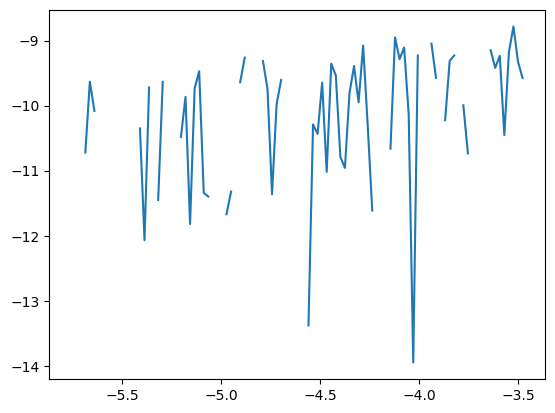

In [41]:
plt.plot(np.log(grads),np.log(vs))

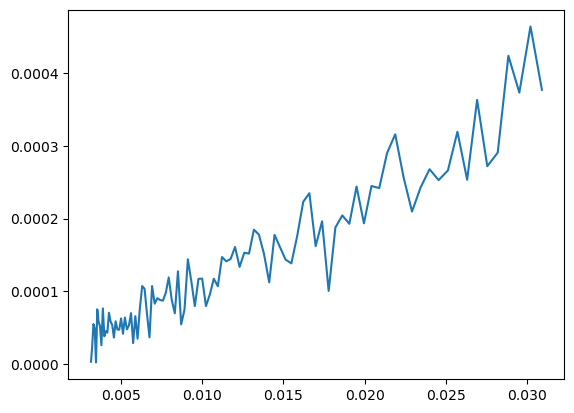

In [102]:
plt.plot(grads,vs)

In [118]:
np.exp(1)

2.718281828459045

In [119]:
ratio = 1/np.exp(1)
vs2 = getOrientedPerturbingDiffusionCoef(actionsData,ratio,grads,10,1000000)
#np.save("/R=1/"+ str(datetime.datetime.now()) ,vs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


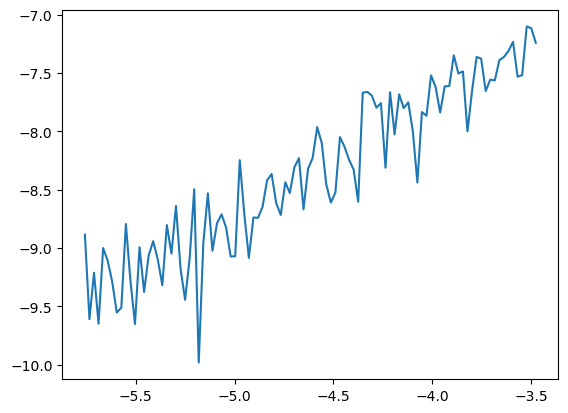

In [120]:
plt.plot(np.log(grads),np.log(vs2))

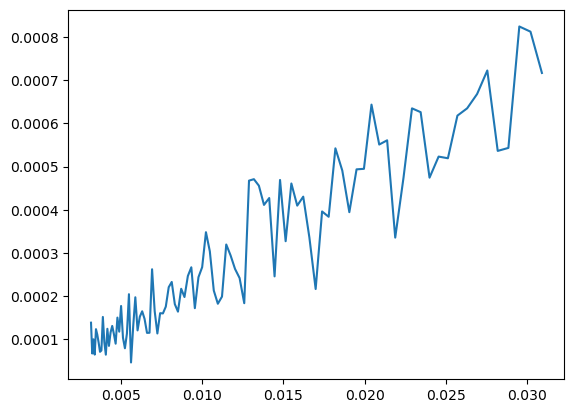

In [121]:
plt.plot(grads,vs2)

In [122]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(grads,vs)
slope, intercept, r_value, p_value, std_err

(0.011931841392813664,
 -6.121765171160907e-06,
 0.9494948955889817,
 3.952436280418299e-51,
 0.00039831850881333943)

In [123]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(grads,vs2)
slope, intercept, r_value, p_value, std_err

(0.023547777282157636,
 9.050804099117833e-06,
 0.9383980316728878,
 5.094305694868909e-47,
 0.0008759283204839124)

In [41]:
slope, intercept, r_value, p_value, std_err

(0.9924219263305574,
 -4.520408391214021,
 0.9946631409333909,
 1.730238413907882e-98,
 0.010398840975252297)

NameError: name 'vs' is not defined

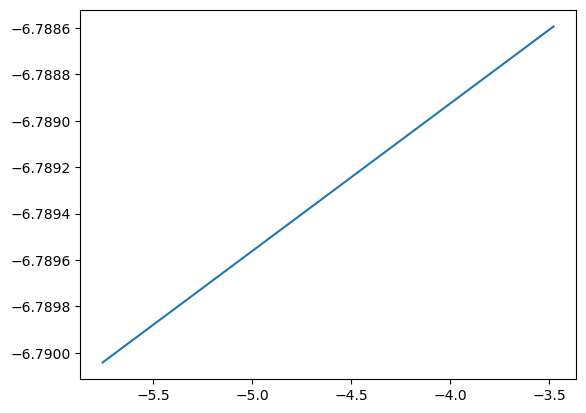

In [70]:
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept+slope*np.log(grads[0]),intercept+slope*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(vs))
plt.savefig("plor2.png")

In [43]:
ratio2 = 10
vs2 = getOrientedPerturbingDiffusionCoef(actionsData,ratio2,grads,100,100000)
np.save("vsData2f",vs2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [37]:
ratio3 = 100
vs3 = getOrientedPerturbingDiffusionCoef(actionsData,ratio3,grads,100,100000)
np.save("vsData3f",vs3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [38]:
ratio4 = 0.1
vs4 = getOrientedPerturbingDiffusionCoef(actionsData,ratio4,grads,100,100000)
np.save("vsData4f",vs4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [79]:
ratio5 = 0.01
vs5 = getOrientedPerturbingDiffusionCoef(actionsData,ratio5,grads,100,1000000)
np.save("vsData5f",vs5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [44]:
import scipy 

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
da1 = np.load("vsDataf.npy")
da2 = np.load("vsData2f.npy")
da3 = np.load("vsData3f.npy")
da4 = np.load("vsData4f.npy")
da5 = np.load("vsData5f.npy")

grads = 10**(np.arange(-250,-150)/100)

FileNotFoundError: [Errno 2] No such file or directory: 'vsDataf.npy'

In [9]:
slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(np.log(grads),np.log(da1))
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept1+slope1*np.log(grads[0]),intercept1+slope1*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(da1))
plt.xlabel("$ln(\\nabla c)$")
plt.ylabel("$ln(u)$")
plt.savefig("5_2.png")

NameError: name 'da1' is not defined

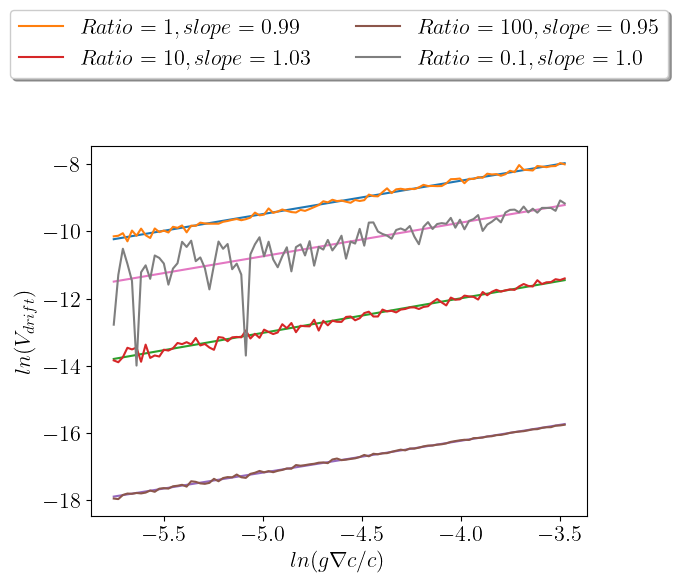

In [70]:
plt.Figure(figsize=(10,10))
# plt.title("log(drift-velocity) vs log(grad(c)/c)")
plt.xlabel("$ln(g\\nabla c/c)$")
plt.ylabel("$ln(V_{drift})$")

slope1, intercept1, r_value1, p_value1, std_err1 = scipy.stats.linregress(np.log(grads),np.log(da1))
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept1+slope1*np.log(grads[0]),intercept1+slope1*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(da1), label=f'$Ratio=1,slope={np.round(slope1,2)}$')

slope2, intercept2, r_value2, p_value2, std_err2 = scipy.stats.linregress(np.log(grads),np.log(da2))
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept2+slope2*np.log(grads[0]),intercept2+slope2*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(da2), label=f'$Ratio=10,slope={np.round(slope2,2)}$')

slope3, intercept3, r_value3, p_value3, std_err3 = scipy.stats.linregress(np.log(grads),np.log(m5))
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept3+slope3*np.log(grads[0]),intercept3+slope3*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(m5), label=f'$Ratio=100,slope={np.round(slope3,2)}$')

slope4, intercept4, r_value4, p_value4, std_err4 = scipy.stats.linregress(np.log(grads),np.log(da4))
plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept4+slope4*np.log(grads[0]),intercept4+slope4*np.log(grads[-1])])
plt.plot(np.log(grads),np.log(da4), label=f'$Ratio=0.1,slope={np.round(slope4,2)}$')

# slope5, intercept5, r_value5, p_value5, std_err5 = scipy.stats.linregress(np.log(grads),np.log(da5))
# plt.plot([np.log(grads[0]),np.log(grads[-1])], [intercept5+slope5*np.log(grads[0]),intercept5+slope5*np.log(grads[-1])], label='Ratio 0.01 Line')
# plt.plot(np.log(grads),np.log(da5), label='Ratio 0.01')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=2, fancybox=True, shadow=True)

plt.savefig("./plotDrift.png")


In [51]:
np.exp(-5.5)

0.004086771438464067

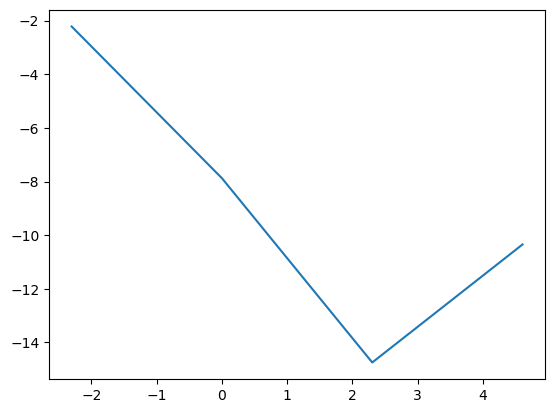

In [19]:
ins = [intercept1,intercept2,intercept3,intercept4]
rats = [0.1,1,10,100]
plt.plot(np.log(rats),np.log(np.exp(ins)/np.array(rats)))

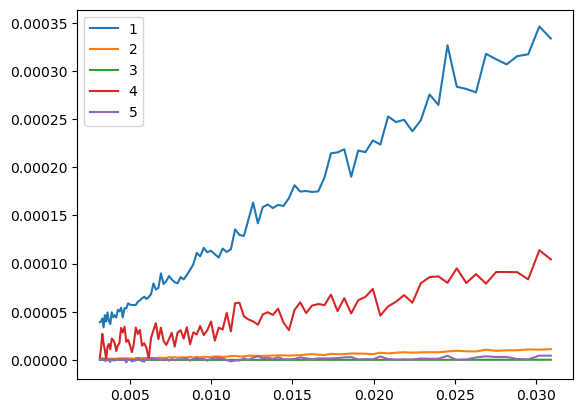

In [47]:
plt.plot(grads,da1)
plt.plot(grads,da2)
plt.plot(grads,da3)
plt.plot(grads,da4)
plt.plot(grads,da5)
plt.legend([1,2,3,4,5])

In [54]:
import glob
l1 = glob.glob("/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=1/*.npy")
l2 = glob.glob("/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=0.1/*.npy")
l3 = glob.glob("/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=0.01/*.npy")
l4 = glob.glob("/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=10/*.npy")
l5 = glob.glob("/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=100/*.npy")

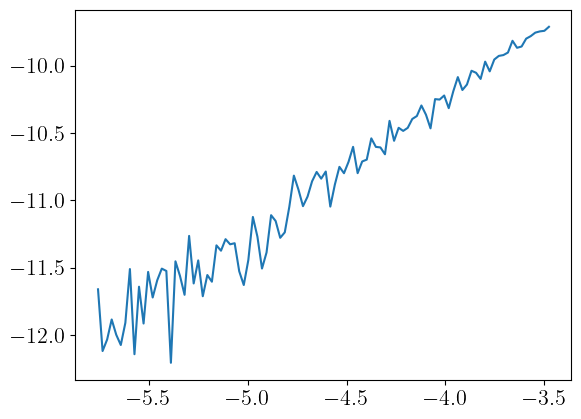

In [55]:
m1 = np.zeros(100)
for i in l1:
    m1 += np.load(i)

m1 /= len(l1)


plt.plot(np.log(grads),np.log(m1))

/tmp/ipykernel_16338/115812926.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(grads),np.log(m2))


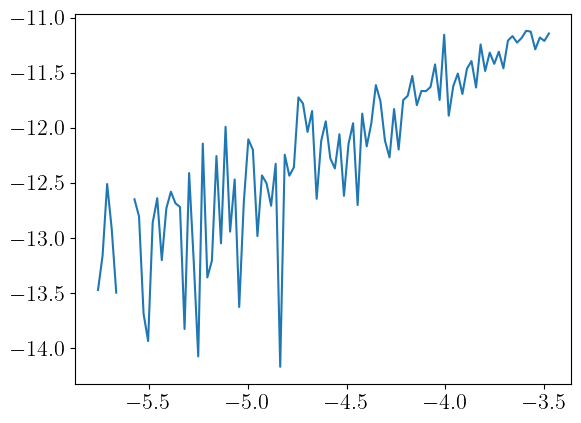

In [56]:
m2 = np.zeros(100)
for i in l2:
    m2 += np.load(i)

m2 /= len(l2)


plt.plot(np.log(grads),np.log(m2))

/tmp/ipykernel_16338/2327261501.py:8: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(grads),np.log(m3))


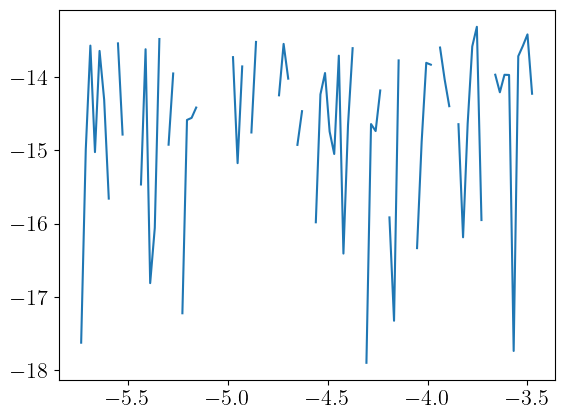

In [57]:
m3 = np.zeros(100)
for i in l3:
    m3 += np.load(i)

m3 /= len(l3)


plt.plot(np.log(grads),np.log(m3))

In [37]:
m4 = np.zeros(100)
for i in l4:
    m4 += np.load(i,allow_pickle=True)

m4 /= len(l4)


plt.plot(np.log(grads),np.log(m4))

UnpicklingError: Failed to interpret file '/home/alireza-astane/PycharmProjects/UniProjects/swimmerProject/Datas/R=10/2024-03-29 05:38:03.440508.npy' as a pickle

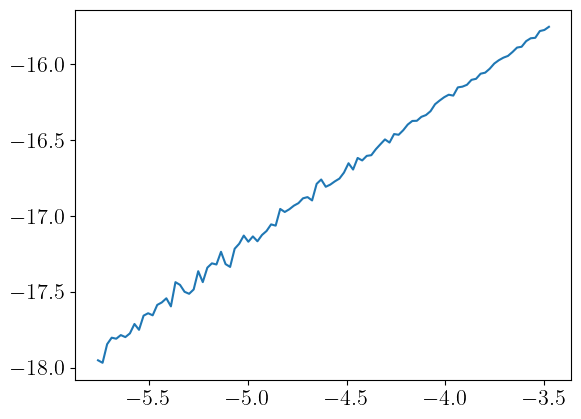

In [58]:
m5 = np.zeros(100)
for i in l5:
    m5 += np.load(i)

m5 /= len(l5)


plt.plot(np.log(grads),np.log(m5))

In [42]:
testRs = np.exp(np.arange(-5,6)/10 + np.log(ratios[18])) 
testRs

array([0.16097107, 0.17790055, 0.19661051, 0.21728822, 0.24014062,
       0.26539643, 0.29330842, 0.32415593, 0.35824771, 0.39592495,
       0.43756474])

In [41]:
testRs2 = np.exp(np.arange(-30,30,6)/10 + np.log(ratios[18]))
testRs2,np.log(testRs2)

(array([0.01321331, 0.02407622, 0.04386973, 0.07993587, 0.14565265,
        0.26539643, 0.48358382, 0.88114718, 1.60555483, 2.92551165]),
 array([-4.32653061, -3.72653061, -3.12653061, -2.52653061, -1.92653061,
        -1.32653061, -0.72653061, -0.12653061,  0.47346939,  1.07346939]))

In [170]:
for i in range(testRs.shape[0]):
    vsTest = getOrientedPerturbingDiffusionCoef(actionsData,testRs[i],grads,10,1000000)
    print("test" ,i)
    np.save(f"test{i}",vsTest)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39

In [71]:
vsTest0 = np.load("test0.npy")
vsTest1 = np.load("test1.npy")
vsTest2 = np.load("test2.npy")
vsTest3 = np.load("test3.npy")
vsTest4 = np.load("test4.npy")
vsTest5 = np.load("test5.npy")
vsTest6 = np.load("test6.npy")
vsTest7 = np.load("test7.npy")
vsTest8 = np.load("test8.npy")
vsTest9 = np.load("test9.npy")
vsTest10 = np.load("test10.npy")


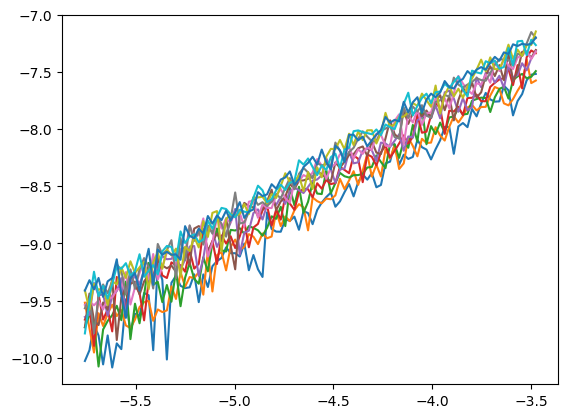

In [44]:
plt.plot(np.log(grads),np.log(vsTest0))
plt.plot(np.log(grads),np.log(vsTest1))
plt.plot(np.log(grads),np.log(vsTest2))
plt.plot(np.log(grads),np.log(vsTest3))
plt.plot(np.log(grads),np.log(vsTest4))
plt.plot(np.log(grads),np.log(vsTest5))
plt.plot(np.log(grads),np.log(vsTest6))
plt.plot(np.log(grads),np.log(vsTest7))
plt.plot(np.log(grads),np.log(vsTest8))
plt.plot(np.log(grads),np.log(vsTest9))
plt.plot(np.log(grads),np.log(vsTest10))

In [45]:
slope0, intercept0, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest0))
slope1, intercept1, r_value1, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest1))
slope2, intercept2, r_value2, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest2))
slope3, intercept3, r_value3, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3))
slope4, intercept4, r_value4, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4))
slope5, intercept5, r_value5, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest5))
slope6, intercept6, r_value6, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest6))
slope7, intercept7, r_value7, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest7))
slope8, intercept8, r_value8, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest8))
slope9, intercept9, r_value9, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest9))
slope10, intercept10, r_value10, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest10))


In [46]:
slope0,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,slope9,slope10

(1.042734383126584,
 1.0148462196036485,
 1.0126359421516,
 0.9954927599942379,
 0.974081246650425,
 1.018979157999716,
 0.9916513150855297,
 0.9998872188511587,
 1.0083578266731674,
 1.0025972290890977,
 1.01427909048831)

In [63]:
testIntercepts = np.array([intercept0,intercept1,intercept2,intercept3,intercept4,intercept5,intercept6,intercept7,intercept8,intercept9,intercept10])
testIntercepts

array([-3.9301504 , -3.99691862, -3.94124826, -3.95317639, -3.98919504,
       -3.75794891, -3.84676342, -3.76974594, -3.70956206, -3.71878742,
       -3.65712624])

In [64]:
r_value0,r_value1,r_value2,r_value3,r_value4,r_value5,r_value6,r_value7,r_value8,r_value9,r_value10

(0.9833285581592448,
 0.9904358558483285,
 0.9878540794886451,
 0.9899868145211528,
 0.9915907821675194,
 0.9896266392092778,
 0.9934320772926399,
 0.9921106801406635,
 0.9925939021595437,
 0.9932748485322112,
 0.9933465710657045)

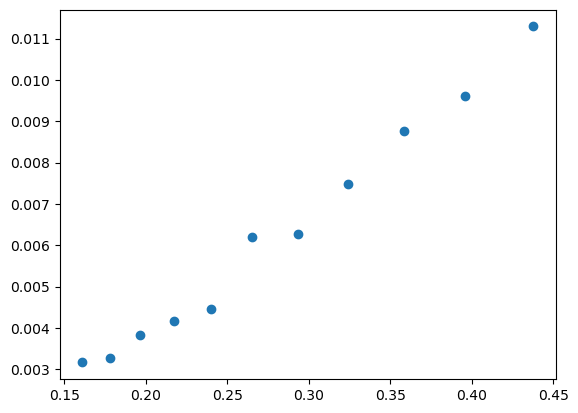

In [65]:
plt.scatter(testRs,np.exp(testIntercepts)*testRs)

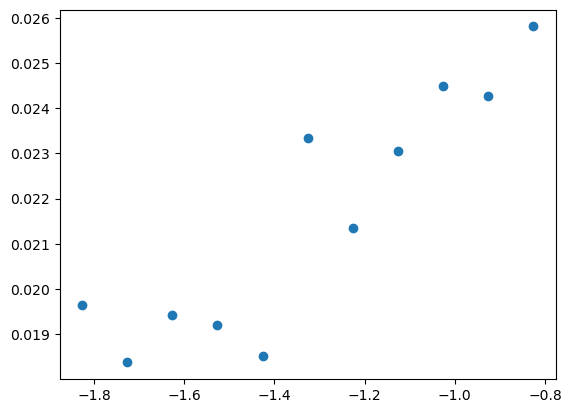

In [66]:
plt.Figure(figsize=(20,20))
plt.scatter(np.log(testRs),np.exp(testIntercepts))
plt.savefig("res.jpg")

In [187]:
for i in range(testRs2.shape[0]):
    vsTest = getOrientedPerturbingDiffusionCoef(actionsData,testRs2[i],grads,10,1000000)
    print("test2_" ,i)
    np.save(f"test2_{i}",vsTest)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test2_ 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test2_ 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
test2_ 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37

In [47]:
vsTest2_0 = np.load("test2_0.npy")
vsTest2_1 = np.load("test2_1.npy")
vsTest2_2 = np.load("test2_2.npy")
vsTest2_3 = np.load("test2_3.npy")
vsTest2_4 = np.load("test2_4.npy")
vsTest2_5 = np.load("test2_5.npy")
vsTest2_6 = np.load("test2_6.npy")
vsTest2_7 = np.load("test2_7.npy")
vsTest2_8 = np.load("test2_8.npy")
vsTest2_9 = np.load("test2_9.npy")


/tmp/ipykernel_15263/1999924306.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(grads),np.log(vsTest2_0))
/tmp/ipykernel_15263/1999924306.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(grads),np.log(vsTest2_1))


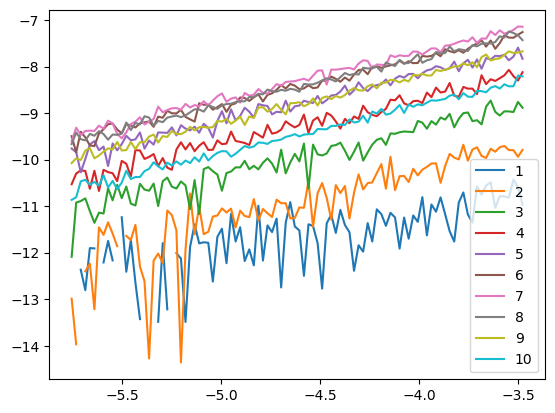

In [48]:
plt.plot(np.log(grads),np.log(vsTest2_0))
plt.plot(np.log(grads),np.log(vsTest2_1))
plt.plot(np.log(grads),np.log(vsTest2_2))
plt.plot(np.log(grads),np.log(vsTest2_3))
plt.plot(np.log(grads),np.log(vsTest2_4))
plt.plot(np.log(grads),np.log(vsTest2_5))
plt.plot(np.log(grads),np.log(vsTest2_6))
plt.plot(np.log(grads),np.log(vsTest2_7))
plt.plot(np.log(grads),np.log(vsTest2_8))
plt.plot(np.log(grads),np.log(vsTest2_9))
plt.legend([1,2,3,4,5,6,7,8,9,10])


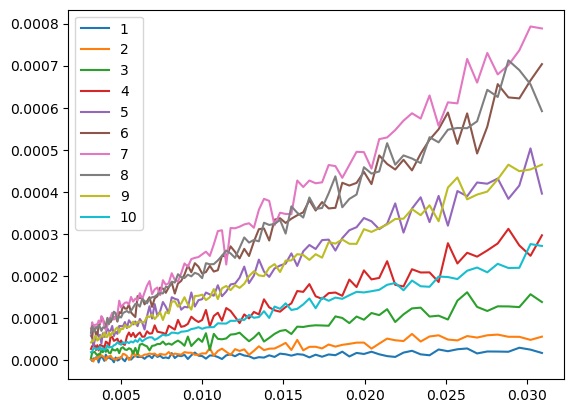

In [49]:
plt.plot(grads,vsTest2_0)
plt.plot(grads,vsTest2_1)
plt.plot(grads,vsTest2_2)
plt.plot(grads,vsTest2_3)
plt.plot(grads,vsTest2_4)
plt.plot(grads,vsTest2_5)
plt.plot(grads,vsTest2_6)
plt.plot(grads,vsTest2_7)
plt.plot(grads,vsTest2_8)
plt.plot(grads,vsTest2_9)
plt.legend([1,2,3,4,5,6,7,8,9,10])

In [50]:
slope0, intercept0, r_value0, _,_ = scipy.stats.linregress(grads,vsTest2_0)
slope1, intercept1, r_value1, _,_ = scipy.stats.linregress(grads,vsTest2_1)
slope2, intercept2, r_value2, _,_ = scipy.stats.linregress(grads,vsTest2_2)
slope3, intercept3, r_value3, _,_ = scipy.stats.linregress(grads,vsTest2_3)
slope4, intercept4, r_value4, _,_ = scipy.stats.linregress(grads,vsTest2_4)
slope5, intercept5, r_value5, _,_ = scipy.stats.linregress(grads,vsTest2_5)
slope6, intercept6, r_value6, _,_ = scipy.stats.linregress(grads,vsTest2_6)
slope7, intercept7, r_value7, _,_ = scipy.stats.linregress(grads,vsTest2_7)
slope8, intercept8, r_value8, _,_ = scipy.stats.linregress(grads,vsTest2_8)
slope9, intercept9, r_value9, _,_ = scipy.stats.linregress(grads,vsTest2_9)

In [71]:
slopes = np.array([slope0,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,slope9])
slopes

array([0.00070572, 0.00210549, 0.00477561, 0.00923167, 0.01488219,
       0.02144623, 0.02520704, 0.02183549, 0.015251  , 0.00815913])

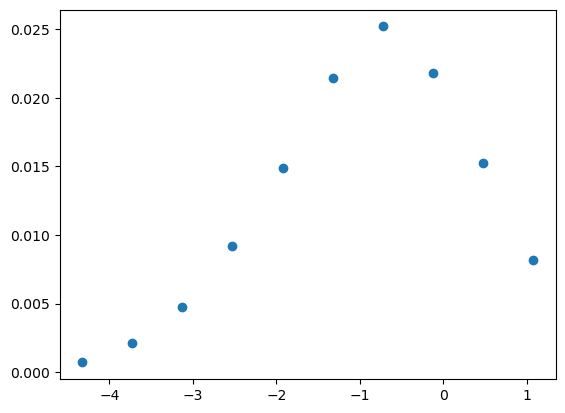

In [72]:
plt.scatter(np.log(testRs2),slopes)

In [207]:
testRs2

array([0.01321331, 0.02407622, 0.04386973, 0.07993587, 0.14565265,
       0.26539643, 0.48358382, 0.88114718, 1.60555483, 2.92551165])

In [38]:
testRs3 = np.exp(np.linspace(-1,0,20))
testRs3

array([0.36787944, 0.3877601 , 0.40871514, 0.43080262, 0.45408372,
       0.47862297, 0.50448835, 0.53175153, 0.56048804, 0.59077751,
       0.62270386, 0.65635556, 0.69182583, 0.72921295, 0.76862053,
       0.81015773, 0.85393967, 0.90008763, 0.94872948, 1.        ])

array([-2.        , -1.84210526, -1.68421053, -1.52631579, -1.36842105,
       -1.21052632, -1.05263158, -0.89473684, -0.73684211, -0.57894737,
       -0.42105263, -0.26315789, -0.10526316,  0.05263158,  0.21052632,
        0.36842105,  0.52631579,  0.68421053,  0.84210526,  1.        ])

In [59]:
testRs3 = np.exp(np.linspace(-1,0,20))

for i in range(testRs3.shape[0]):
    vsTest = getOrientedPerturbingDiffusionCoef(actionsData,testRs3[i],grads,50,100_000)
    print("test4_" +str(i))
    np.save(f"test4_{i}",vsTest)

0
1


SystemError: CPUDispatcher(<function getOrientedPerturbingDiffusionCoefForRatio at 0x7f5cbb21fe20>) returned a result with an exception set

In [74]:
vsTest3_0 = np.load("test3_0.npy")
vsTest3_1 = np.load("test3_1.npy")
vsTest3_2 = np.load("test3_2.npy")
vsTest3_3 = np.load("test3_3.npy")
vsTest3_4 = np.load("test3_4.npy")
vsTest3_5 = np.load("test3_5.npy")
vsTest3_6 = np.load("test3_6.npy")
vsTest3_7 = np.load("test3_7.npy")
vsTest3_8 = np.load("test3_8.npy")
vsTest3_9 = np.load("test3_9.npy")
vsTest3_10 = np.load("test3_10.npy")
vsTest3_11 = np.load("test3_11.npy")
vsTest3_12= np.load("test3_12.npy")
vsTest3_13 = np.load("test3_13.npy")
vsTest3_14= np.load("test3_14.npy")
vsTest3_15 = np.load("test3_15.npy")
vsTest3_16= np.load("test3_16.npy")
vsTest3_17= np.load("test3_17.npy")
vsTest3_18= np.load("test3_18.npy")
vsTest3_19 = np.load("test3_19.npy")


In [230]:
np.log(testRs3)

array([-2.        , -1.84210526, -1.68421053, -1.52631579, -1.36842105,
       -1.21052632, -1.05263158, -0.89473684, -0.73684211, -0.57894737,
       -0.42105263, -0.26315789, -0.10526316,  0.05263158,  0.21052632,
        0.36842105,  0.52631579,  0.68421053,  0.84210526,  1.        ])

In [41]:
plt.plot(np.log(grads),np.log(vsTest3_0))
plt.plot(np.log(grads),np.log(vsTest3_1))
plt.plot(np.log(grads),np.log(vsTest3_2))
plt.plot(np.log(grads),np.log(vsTest3_3))
plt.plot(np.log(grads),np.log(vsTest3_4))
plt.plot(np.log(grads),np.log(vsTest3_5))
plt.plot(np.log(grads),np.log(vsTest3_6))
plt.plot(np.log(grads),np.log(vsTest3_7))
plt.plot(np.log(grads),np.log(vsTest3_8))
plt.plot(np.log(grads),np.log(vsTest3_9))
plt.plot(np.log(grads),np.log(vsTest3_10))
plt.plot(np.log(grads),np.log(vsTest3_11))
plt.plot(np.log(grads),np.log(vsTest3_12))
plt.plot(np.log(grads),np.log(vsTest3_13))
plt.plot(np.log(grads),np.log(vsTest3_14))
plt.plot(np.log(grads),np.log(vsTest3_15))
plt.plot(np.log(grads),np.log(vsTest3_16))
plt.plot(np.log(grads),np.log(vsTest3_17))
plt.plot(np.log(grads),np.log(vsTest3_18))
plt.plot(np.log(grads),np.log(vsTest3_19))
plt.legend([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

NameError: name 'vsTest3_0' is not defined

In [76]:
slope0, intercept0, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_0))
slope1, intercept1, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_1))
slope2, intercept2, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_2))
slope3, intercept3, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_3))
slope4, intercept4, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_4))
slope5, intercept5, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_5))
slope6, intercept6, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_6))
slope7, intercept7, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_7))
slope8, intercept8, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_8))
slope9, intercept9, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_9))
slope10, intercept10, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_10))
slope11, intercept11, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_11))
slope12, intercept12, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_12))
slope13, intercept13, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_13))
slope14, intercept14, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_14))
slope15, intercept15, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_15))
slope16, intercept16, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_16))
slope17, intercept17, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_17))
slope18, intercept18, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_18))
slope19, intercept19, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest3_19))


In [77]:
slopes = np.array([slope0,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,slope9,slope10,slope11,slope12,slope13,slope14,slope15,slope16,slope17,slope18,slope19])
slopes

array([1.01134832, 0.97879841, 0.99473168, 0.98477648, 0.99807138,
       0.99377985, 0.98069015, 0.9960977 , 0.9853216 , 1.00837458,
       1.00327346, 1.00307678, 1.00681983, 1.01289946, 1.01204011,
       1.01184832, 1.00365271, 1.01925293, 1.02519167, 1.02302769])

In [78]:
testIntercepts = np.array([intercept0,intercept1,intercept2,intercept3,intercept4,intercept5,intercept6,intercept7,intercept8,intercept9,intercept10,intercept11,intercept12,intercept13,intercept14,intercept15,intercept16,intercept17,intercept18,intercept19,])
testIntercepts

array([-4.17381506, -4.21882942, -4.05199208, -4.00550636, -3.85473242,
       -3.81617154, -3.84272553, -3.73788331, -3.77441072, -3.67808751,
       -3.71437638, -3.75998499, -3.79574096, -3.84811487, -3.94680254,
       -4.06216419, -4.23113695, -4.31001792, -4.44946627, -4.65986931])

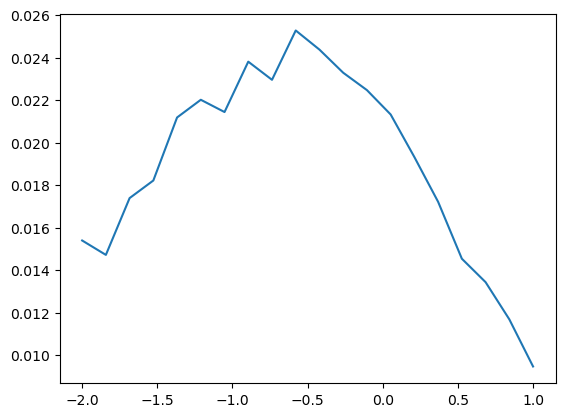

In [81]:
plt.Figure(figsize=(20,20))
plt.plot(np.log(testRs3),np.exp(testIntercepts))

In [10]:
grad = np.exp(-3.5)
grad

0.0301973834223185

In [ ]:
slopes_1 = np.load("slopes_1.npy")
slopes_2 = np.load("slopes_2.npy")

print(slopes_1.shape)
print(slopes_2.shape)
print()

(20,)
(100,)


In [18]:
slopes_1

array([0.02145   , 0.01971015, 0.01924723, 0.01751368, 0.01668066,
       0.01513135, 0.01416998, 0.01250411, 0.01078158, 0.0097174 ,
       0.0086847 , 0.00751209, 0.006499  , 0.00577601, 0.0049836 ,
       0.00438962, 0.00358003, 0.00310578, 0.00261733, 0.00227683])

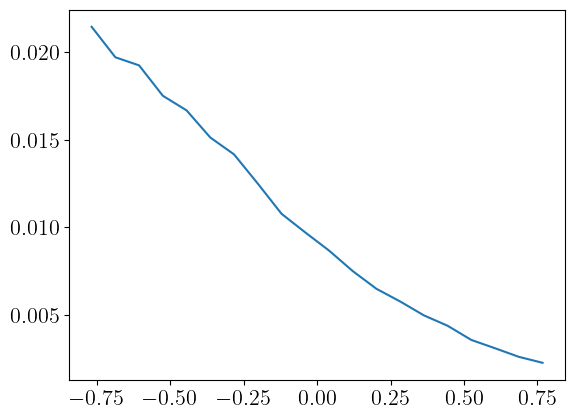

In [17]:
plt.plot(np.log(testRs3[40:60]),slopes_1)

In [13]:
# slopes1 = np.load("slopes_0.npy")
# slopes = np.load("slopes_1.npy")

testRs3a = np.exp(np.linspace(-4,4,100))
testRs3 = np.exp(np.linspace(-4,4,100))
myRs = np.concatenate([testRs3a[:24],testRs3 , testRs3a[50:]]) 
mySlopes = np.concatenate([slopes_2[:24], slopes_1  ,  slopes_2[50:] ] )


plt.plot(np.log(myRs),mySlopes*myRs)
plt.xlabel("ln(c)")
plt.ylabel("f(c)")
plt.savefig("5_5.png")

ValueError: operands could not be broadcast together with shapes (94,) (174,) 

In [85]:
slopes = np.zeros_like(testRs3)


for i in range(testRs3.shape[0]):
    meanFinalTimes,meanFinalPoses = getOrientedPerturbingDiffusionCoefForRatio(actionsData,testRs3[i],grad,10,10_000_000)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(meanFinalTimes,meanFinalPoses)
    print(i ,r_value )
    slopes[i] = slope




0 0.9991573926639439
1 0.9993679300914626
2 0.9996546283560546
3 0.998997216194206
4 0.9994372487784684
5 0.9990410996198585
6 0.9992257263485596
7 0.998321845260593
8 0.999723073130561
9 0.9989441580425756
10 0.9995672377429277
11 0.9995998498344127
12 0.9981142407099457
13 0.9998753576111977
14 0.9993357191970125
15 0.998818995326574
16 0.9998874233307352
17 0.9997028242969442
18 0.9995743223328989
19 0.9997505421228
20 0.9998421581871748
21 0.9998733486885708
22 0.9998706902732333
23 0.9998005496138928
24 0.9997209668906936
25 0.9998406867373177
26 0.9998360822651441
27 0.999937005820308
28 0.999861469421305
29 0.9999121453907479
30 0.999965810918343
31 0.9998973998553509
32 0.9999378989987154
33 0.9996927280135769
34 0.9999229547924091
35 0.9998882525647864
36 0.9998759600045082
37 0.9999434376666776
38 0.9998946292530531
39 0.9999204303330371
40 0.9999407959662269
41 0.9999583669549722
42 0.9999368452153176
43 0.999952037094313
44 0.9999815093791036
45 0.9999567287706375
46 0.9998

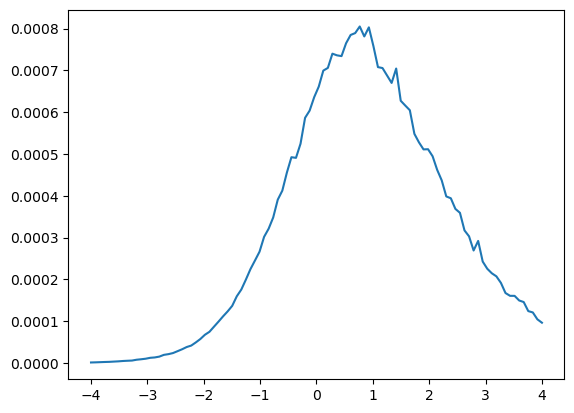

In [87]:
plt.plot(np.log(testRs3),slopes*testRs3)

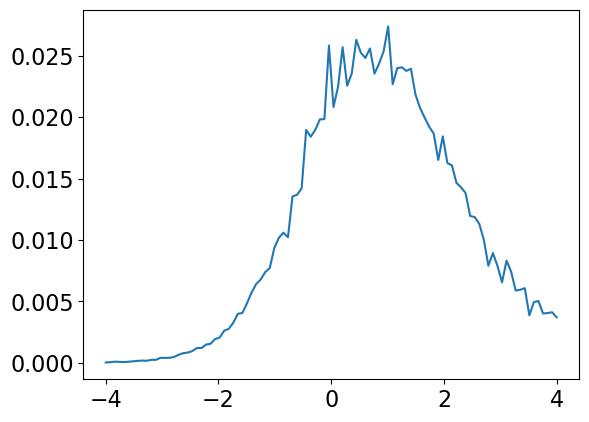

In [45]:
plt.plot(np.log(testRs3a),slopes1*testRs3a)


NameError: name 'testRs3a' is not defined

In [41]:
np.max(np.concatenate([slopes1[:24], slopes  ,  slopes1[50:] ] ))

0.026014122070595256

In [42]:
np.argmax(np.concatenate([slopes1[:24], slopes  ,  slopes1[50:] ] ))

37

In [44]:
np.concatenate([testRs3a[:24],testRs3 , testRs3a[50:]])[37]

0.5317515301305706

In [45]:
np.log(0.5317515301305706)

-0.6315789473684211

In [85]:
testRs3a

array([1.83156389e-02, 1.98571344e-02, 2.15283666e-02, 2.33402543e-02,
       2.53046355e-02, 2.74343447e-02, 2.97432961e-02, 3.22465753e-02,
       3.49605375e-02, 3.79029144e-02, 4.10929300e-02, 4.45514262e-02,
       4.83009992e-02, 5.23661468e-02, 5.67734286e-02, 6.15516396e-02,
       6.67319983e-02, 7.23483504e-02, 7.84373905e-02, 8.50389013e-02,
       9.21960138e-02, 9.99554889e-02, 1.08368023e-01, 1.17488580e-01,
       1.27376748e-01, 1.38097133e-01, 1.49719775e-01, 1.62320611e-01,
       1.75981969e-01, 1.90793105e-01, 2.06850788e-01, 2.24259931e-01,
       2.43134276e-01, 2.63597138e-01, 2.85782213e-01, 3.09834445e-01,
       3.35910981e-01, 3.64182192e-01, 3.94832786e-01, 4.28063021e-01,
       4.64090006e-01, 5.03149122e-01, 5.45495564e-01, 5.91406001e-01,
       6.41180388e-01, 6.95143928e-01, 7.53649191e-01, 8.17078421e-01,
       8.85846033e-01, 9.60401320e-01, 1.04123139e+00, 1.12886434e+00,
       1.22387273e+00, 1.32687729e+00, 1.43855101e+00, 1.55962350e+00,
      

In [86]:
testRs3

array([0.13533528, 0.1503579 , 0.16704807, 0.18559089, 0.20619203,
       0.22907995, 0.2545085 , 0.28275969, 0.31414685, 0.34901807,
       0.3877601 , 0.43080262, 0.47862297, 0.53175153, 0.59077751,
       0.65635556, 0.72921295, 0.81015773, 0.90008763, 1.        ])

In [96]:
testRs3a[24],testRs3a[50]

(0.1273767484673777, 1.0412313887650417)

In [88]:
np.save(f"slopes_3",slopes/grad)

In [42]:
vsTest4_0 = np.load("test4_0.npy")
vsTest4_1 = np.load("test4_1.npy")
vsTest4_2 = np.load("test4_2.npy")
vsTest4_3 = np.load("test4_3.npy")
vsTest4_4 = np.load("test4_4.npy")
vsTest4_5 = np.load("test4_5.npy")
vsTest4_6 = np.load("test4_6.npy")
vsTest4_7 = np.load("test4_7.npy")
vsTest4_8 = np.load("test4_8.npy")
vsTest4_9 = np.load("test4_9.npy")
vsTest4_10 = np.load("test4_10.npy")
vsTest4_11 = np.load("test4_11.npy")
vsTest4_12= np.load("test4_12.npy")
vsTest4_13 = np.load("test4_13.npy")
vsTest4_14= np.load("test4_14.npy")
vsTest4_15 = np.load("test4_15.npy")
vsTest4_16= np.load("test4_16.npy")
vsTest4_17= np.load("test4_17.npy")
vsTest4_18= np.load("test4_18.npy")
vsTest4_19 = np.load("test4_19.npy")

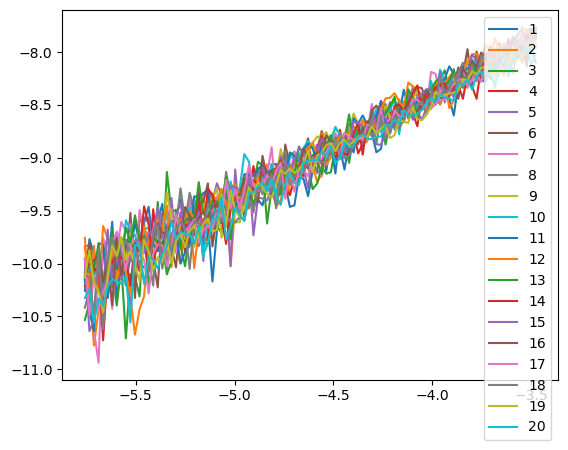

In [43]:
plt.plot(np.log(grads),np.log(vsTest4_0))
plt.plot(np.log(grads),np.log(vsTest4_1))
plt.plot(np.log(grads),np.log(vsTest4_2))
plt.plot(np.log(grads),np.log(vsTest4_3))
plt.plot(np.log(grads),np.log(vsTest4_4))
plt.plot(np.log(grads),np.log(vsTest4_5))
plt.plot(np.log(grads),np.log(vsTest4_6))
plt.plot(np.log(grads),np.log(vsTest4_7))
plt.plot(np.log(grads),np.log(vsTest4_8))
plt.plot(np.log(grads),np.log(vsTest4_9))
plt.plot(np.log(grads),np.log(vsTest4_10))
plt.plot(np.log(grads),np.log(vsTest4_11))
plt.plot(np.log(grads),np.log(vsTest4_12))
plt.plot(np.log(grads),np.log(vsTest4_13))
plt.plot(np.log(grads),np.log(vsTest4_14))
plt.plot(np.log(grads),np.log(vsTest4_15))
plt.plot(np.log(grads),np.log(vsTest4_16))
plt.plot(np.log(grads),np.log(vsTest4_17))
plt.plot(np.log(grads),np.log(vsTest4_18))
plt.plot(np.log(grads),np.log(vsTest4_19))
plt.legend([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

In [44]:
slope0, intercept0, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_0))
slope1, intercept1, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_1))
slope2, intercept2, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_2))
slope3, intercept3, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_3))
slope4, intercept4, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_4))
slope5, intercept5, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_5))
slope6, intercept6, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_6))
slope7, intercept7, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_7))
slope8, intercept8, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_8))
slope9, intercept9, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_9))
slope10, intercept10, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_10))
slope11, intercept11, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_11))
slope12, intercept12, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_12))
slope13, intercept13, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_13))
slope14, intercept14, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_14))
slope15, intercept15, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_15))
slope16, intercept16, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_16))
slope17, intercept17, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_17))
slope18, intercept18, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_18))
slope19, intercept19, r_value0, _,_ = scipy.stats.linregress(np.log(grads),np.log(vsTest4_19))

In [45]:
slopes = np.array([slope0,slope1,slope2,slope3,slope4,slope5,slope6,slope7,slope8,slope9,slope10,slope11,slope12,slope13,slope14,slope15,slope16,slope17,slope18,slope19])
slopes

array([0.92248175, 1.06593161, 1.01564601, 0.98276277, 0.98058833,
       1.00144474, 1.01847159, 1.03858884, 1.00227724, 0.97662572,
       1.02122349, 1.00897902, 0.99523528, 1.00997604, 1.02165154,
       0.99527837, 1.01673181, 1.01653667, 0.9982704 , 1.04794009])

In [47]:
testIntercepts = np.array([intercept0,intercept1,intercept2,intercept3,intercept4,intercept5,intercept6,intercept7,intercept8,intercept9,intercept10,intercept11,intercept12,intercept13,intercept14,intercept15,intercept16,intercept17,intercept18,intercept19,])
testIntercepts

array([-4.80270247, -4.17339772, -4.37123858, -4.48797839, -4.48975264,
       -4.37503989, -4.29452652, -4.21747461, -4.34998063, -4.45477519,
       -4.27190771, -4.29881774, -4.39524005, -4.3610242 , -4.28440672,
       -4.40553416, -4.35703762, -4.37220008, -4.46744386, -4.28794068])

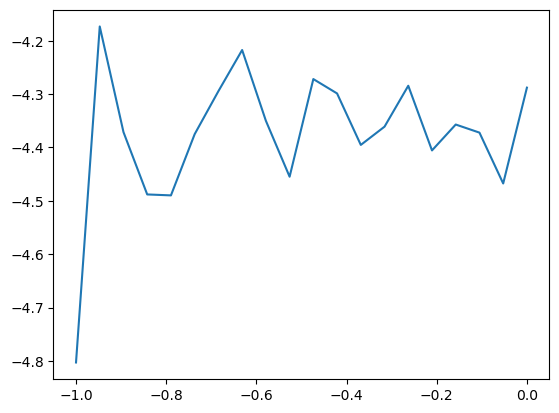

In [49]:
plt.Figure(figsize=(20,20))
plt.plot(np.log(testRs3),np.array(testIntercepts))

In [ ]:
getOrientedPerturbingDiffusionCoefForRatio